length of matrix = 407044
max=
100.0
min=
0.0


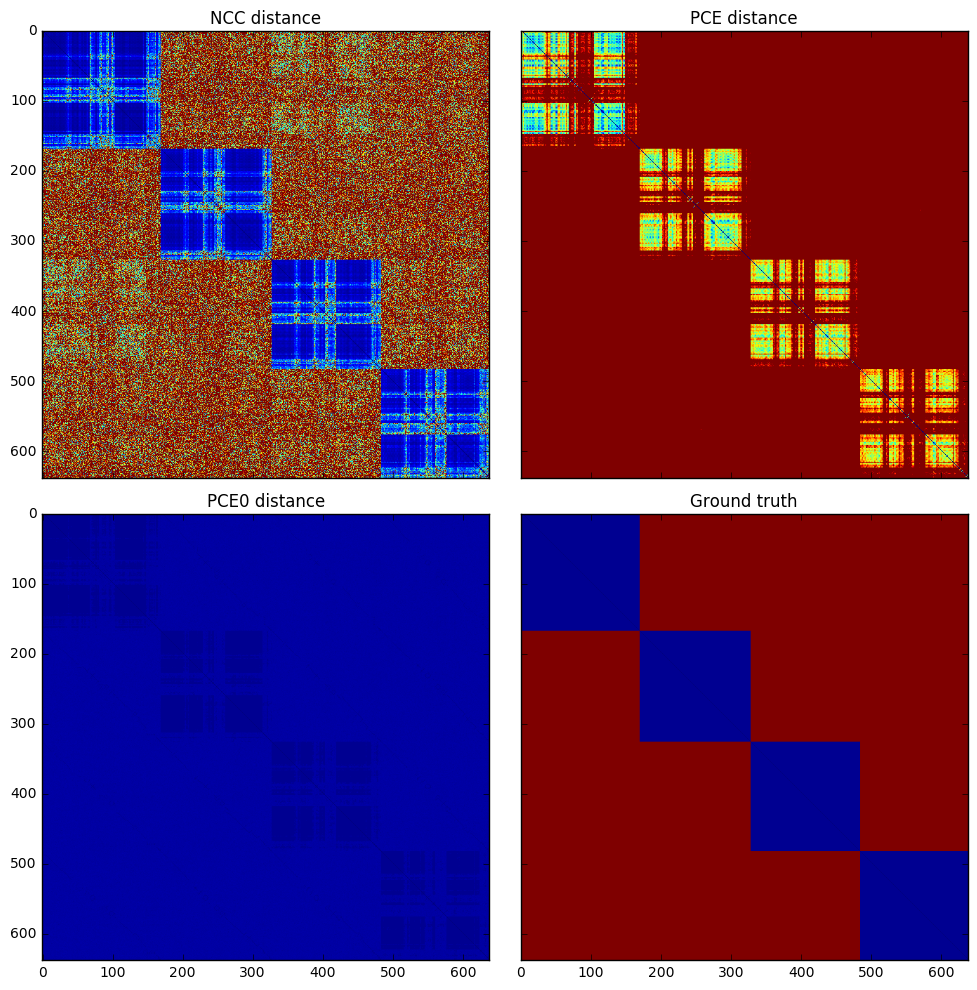

In [1]:
#!/usr/bin/env python

import math
from matplotlib import pyplot
import numpy

import dendro
import exif

import scipy.cluster.hierarchy as sch
from sklearn import metrics

directory = "../data"


max_pce = 60.0
max_ncc = 0.02
    
#all transformations of similarity are monotonic (very important!)

# this transformation streches non-linearly the distances, such that the small distances fall into
# (0,50) and the large into (0,100). 
def transform1(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja   
    if x > 0:
        x = math.log(x)
    else:
        x = 100000 # the diagonal should have the largest values, not 0
        x = math.log(x)
    minx = -22.3000 #min for the given dataset, after the log transformation
    maxx = 11.4900
    x = (x-minx)/(maxx-minx) #normalize to (0,1) 
    if x<0.4:
        x=0.4 #cut off
    if x >0.9:
        x=0.9 # also cut off
    
    if x < 0.76: # the lowest point between both modes of the bi-modal distribution
        a = 1/0.36 # coefficients for the linear transformation
        b = -a*0.4
    else:
        a = 0.414/0.14 
        b = 1-a*0.76
    # after the following transformation, the lowest point is 1, the left-most point is 0 and the right-most point is 2    
    x = a*x + b            
    x = math.pow(x,2) # the non-linear stretching
    maxx = 2 # for x^2
    x = x/maxx # normalize to (0,1)
    x= 1-x # convert from similarity to distance
    x=x*100 #  in the ground  truth the values are 0-100
    return x   

# this transformation streches non-linearly the distances but emphasizes the large distances
def transform(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja   
    if x > 0:
        x = math.log(x)
    else:
        x = 100000 # the diagonal should have the largest values, not 0
        x = math.log(x)
    minx = -22.3000 #min for the given dataset, after the log transformation
    maxx = 11.4900
    x = (x-minx)/(maxx-minx) #normalize to (0,1) 
    if x<0.4:
        x=0.4 #cut off
    if x >0.9:
        x=0.9# also cut off
    x = x/0.36 - 0.4/0.36   # 0.76 is the lowest point og the bi-modal distribution between both modes.With this
    #  transformation, 1 becomes the lowest point, and 0 becomes the left-most point
    x = math.pow(x,3) # non-linear stretching
    maxx = 2.6791838135
    x = x/maxx # normalize to (0,1)
    x= 1-x # convert from similarity to distance
    x=x*100# in  ground  truth the values are 0 to 100
    return x  

#this one again emphasizes the large distances
def transform_orig(x):# hardcoded things need to be replaced by critical points (automated) when possible. To be done by Sonja   
    if x > 0:
        x = math.log(x)
    else:
        x = 100000 # the diagonal should have the largest values, not 0
        x = math.log(x)
    minx = -22.3000
    maxx = 11.4900
    x = (x-minx)/(maxx-minx)
    if x<0.4:
        x=0.4
    if x >0.9:
        x=0.9
    x = x/0.335 - 0.4/0.335    
    x = math.pow(x,3)
    maxx = 3.3248770627 # for x^3
    x = x/maxx
    x= 1-x # convert from similarity to distance
    x=x*100
    return x   


def plot_distance_matrices(matrix1, matrix2, matrix3, matrix4):
    f, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
    ax1.set_adjustable('box-forced')
    ax2.set_adjustable('box-forced')
    ax3.set_adjustable('box-forced')
    ax4.set_adjustable('box-forced')

    vmax = matrix1.max()
    ax1.imshow(matrix1, vmin=0.0, vmax=vmax)
    ax1.set_title("NCC distance")
    ax2.imshow(matrix2, vmin=0.0, vmax=vmax)
    ax2.set_title("PCE distance")
    ax3.imshow(matrix3, vmin=0.0, vmax=vmax)
    ax3.set_title("PCE0 distance")
    ax4.imshow(matrix4, vmin=0.0, vmax=vmax)
    ax4.set_title("Ground truth")

    size = matrix3.shape[0]
    def hover_func(x, y):
        x = int(x+1)
        y = int(y+1)
        if y >= size:
            y = size-1
        if x >= size:
            x = size-1
        return str(x) + "," + str(y) + " " + str(matrix1[y,x]) + " " + str(matrix2[y,x]) + " "+ str(matrix3[y,x])

    ax1.format_coord = hover_func
    ax2.format_coord = hover_func
    ax3.format_coord = hover_func
    ax4.format_coord = hover_func
    f.set_size_inches(10, 10, forward=True)
    f.tight_layout()
    pyplot.show()
    #raw_input()

#function to rename the labels from the found clustering to the labels in the true clustering
#not very useful but may come in handy at some point
def rename_clusters(clustering, true_clustering):
    clustering = numpy.array(clustering)
    #initialize new labels as -1
    labels = numpy.zeros(clustering.shape, dtype=numpy.int) -1
    true_clustering = numpy.array(true_clustering)
    clusters = set(clustering)
    #for each cluster that we found
    for c in clusters:
        #get the ids of the clusters its values really belong to
        true_ids = true_clustering[clustering == c]
        if len(true_ids) > 0:
            id = int(numpy.median(true_ids))
            #using all 80% match here
            #could use most common value or something
            matches = list(true_ids).count(id)
            if matches > 0.8*len(true_ids):
                labels[clustering == c] = id
            #else:
            #    print "problem at c=", c, "id=", id, "true_ids=", true_ids

    #do something with clusters that we could not assign a new name
    for i in range(len(clustering)):
        if labels[i] == -1:
            labels[i] = 9 #assign arbitrary cluster id, lumping everything we could not match into a 'rest' cluster

    return labels

def map_ncc_scores_to_pce_domain(matrix_pce, matrix_ncc):
    #map the ncc values into the range of pce values and shift to align medians
    matrix_ncc = matrix_ncc * (max_pce/max_ncc)
    diff = numpy.median(matrix_pce) - numpy.median(matrix_ncc)      #median works a bit better
    #diff = numpy.average(matrix_pce) - numpy.average(matrix_ncc)
    matrix_ncc += diff
    matrix_ncc[matrix_ncc < 0.0] = 0.0

    return matrix_pce, matrix_ncc

def convert_similarity_to_distance(matrix):# needs to be cleaned and optimized for time
    print("length of matrix = "  + str(len(matrix)))
    i=0
    for element in matrix:
        matrix[i] = transform(element)        
        i+=1    

    #reshape to square matrix form
    numfiles = int(numpy.sqrt(matrix.size))
    matrix = matrix.reshape(numfiles, numfiles)

    #zero diagonal
    index = range(numfiles)
    matrix[index, index] = 0.0

    return matrix


def convert_similarity_to_distance2(matrix):#the original by Ben
    #cut off too high values, the idea is that if it exceeds this threshold it is a hit anyway
    matrix[matrix > max_pce] = max_pce
    matrix[matrix < 0.0] = 0.0

    #prevent div by zero
    matrix += 0.0000001

    #convert similarity score to distance, tried various options
    matrix = max_pce / matrix                 #best for the moment
    #matrix = 200 - matrix
    #matrix = numpy.sqrt(max_pce - matrix)
    #matrix = - numpy.log(matrix/max_pce)     #sort of okay, also had FP

    #set maximum distance at max_pce
    matrix[matrix > max_pce] = max_pce

    #reshape to square matrix form
    numfiles = int(numpy.sqrt(matrix.size))
    matrix = matrix.reshape(numfiles, numfiles)

    #zero diagonal
    index = range(numfiles)
    matrix[index, index] = 0.0

    return matrix

def combine_pce_and_ncc_distances(matrix_pce, matrix_ncc):
    #experiment with methods for combining the distance matrices into one
    matrix = numpy.minimum(matrix_pce, matrix_ncc)  #minimum distance
    #matrix = numpy.sqrt(matrix_pce * matrix_ncc)   #geometric mean
    #matrix = (matrix_pce + matrix_ncc) / 2.0       #arithmetic mean

    #print "pce median max", numpy.median(matrix_pce), matrix_pce.max()
    #print "ncc median max", numpy.median(matrix_ncc), matrix_ncc.max()
    return matrix

def print_metrics(true_clustering, cluster):
    #try some metrics from sklearn
    print ("\n")
    print ("adjusted rand score [-1.0 (bad) to 1.0 (good)]\n", metrics.adjusted_rand_score(true_clustering, cluster))
    print ("mutual information based score [0.0 (bad) to 1.0 (good)]\n", metrics.adjusted_mutual_info_score(true_clustering, cluster))
    #print ("homogeneity, completeness, v measure [0.0 (bad) to 1.0 (good)]\n", metrics.homogeneity_completeness_v_measure(true_clustering, cluster)


def get_ground_truth():
    filelist = numpy.loadtxt(directory + "/filelist.txt", dtype=numpy.string_)
    numfiles = filelist.size    
    matrix_ans = numpy.zeros([numfiles,numfiles], dtype=numpy.float)
    for i in range(numfiles):
        for j in range(numfiles):          
            cam1 = str(filelist[i]).split("_")[:-1]
            cam2 = str(filelist[j]).split("_")[:-1]
            if cam1 == cam2:
                matrix_ans[i][j] = 1.0
            else:
                matrix_ans[i][j] = 100.0
            if i == j:
                matrix_ans[i][j] = 0.0
    return matrix_ans


if True:

    dataset = "pentax" #.argv[1]
    directory = directory + "/" + dataset

    #load the distance matrixes from files
    matrix_pce = numpy.fromfile(directory + "/matrix-" + dataset + "-pce.dat", dtype='>d')
    matrix_pce0 = numpy.fromfile(directory + "/matrix-" + dataset + "-pce0.dat", dtype='>d')
    matrix_ncc = numpy.fromfile(directory + "/matrix-" + dataset + "-ncc.dat", dtype='>d')

    matrix_pce, matrix_ncc = map_ncc_scores_to_pce_domain(matrix_pce, matrix_ncc)
    matrix_ncc = convert_similarity_to_distance2(matrix_ncc)
   
    matrix_pce = convert_similarity_to_distance(matrix_pce)# for now only for PCE the new conversion is used
    # pyplot.hist(matrix_pce, bins =100) # here we draw the histogram of the new distances. Disabled by default because it takes time
    print("max=")
    print(matrix_pce.max())
    print("min=")
    print(matrix_pce.min())
    matrix_pce0 = convert_similarity_to_distance2(matrix_pce0)

    matrix_ans = get_ground_truth()    
    
    plot_distance_matrices(matrix_ncc, matrix_pce, matrix_pce0, matrix_ans)



In [ ]:
#the plotting is crashing ('not responding'), I don't know why. Debugging it in an IDE did not help :(. 
if True:
    #set metric to use for clustering
    matrix = matrix_pce


    #hierarchical clustering part starts here
    linkage = dendro.compute_linkage(matrix)

    #methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
    #for method in methods:
    #    linkage = sch.linkage(matrix, method=method)


    threshold = 0.7*linkage[:,2].max() # default threshold used in sch.dendogram is 0.7*linkage[:,2].max()


    #dendrogram = dendro.compute_dendrogram(linkage)
    dendrogram = dendro.plot_dendrogram_and_matrix(linkage, matrix, color_threshold=threshold)


    #compute flat clustering in the exact same way as sch.dendogram colors the clusters
    cluster = numpy.array(sch.fcluster(linkage, threshold, criterion='distance'), dtype=numpy.int)
    numpy.set_printoptions(threshold=numpy.nan) # make numpy print the full array
    print ("flat clustering:\n", cluster)

    #get the actual clustering
    filelist = numpy.loadtxt(directory + "/filelist.txt", dtype=numpy.string_)
    true_clustering = ["_".join(str(s).split("_")[:-1]) for s in filelist]
    true_clusters = sorted(set(true_clustering))
    true_labels = numpy.array([true_clusters.index(id) for id in true_clustering], dtype=numpy.int)
    print ("true clustering:\n", true_labels)


    print_metrics(true_labels, cluster)




    #go interactive
    #import readline
    #import rlcompleter
    #readline.parse_and_bind("tab: complete")
    #import code
    #code.interact(local=dict(globals(), **locals()))










In [ ]:
407044-406406

In [ ]:
638*637

In [ ]:
math.sqrt(407044)